Ici nous avons pris une nouvelle fonction de loss qui combine la perte sur les exemples propres et adversariaux avec un facteur de pondération 𝛼. Nous avons aussi augmenté le nombre d'unité par couche pour le réseau Large Maxout car il est suggéré que cela pourrait permettre d'augmenter la qualité du réseau. Nous avons de plus mis en lumière le fait que les prédictions ratées du réseau se font avec une grande confiance.


Epoch [1/10], Loss: 0.31546690589604304
Epoch [2/10], Loss: 0.10106229634245031
Epoch [3/10], Loss: 0.08307654472168766
Epoch [4/10], Loss: 0.06508115370945103
Epoch [5/10], Loss: 0.051493250923927335
Epoch [6/10], Loss: 0.05889894492016894
Epoch [7/10], Loss: 0.06315800439285536
Epoch [8/10], Loss: 0.04773237757140545
Epoch [9/10], Loss: 0.09367439680728736
Epoch [10/10], Loss: 0.13624396471337585
Accuracy on adversarial examples: 96.68%
Confiance moyenne sur les exemples mal classifiés : 89.51%
Confiance moyenne sur les exemples mal classifiés : 89.51%


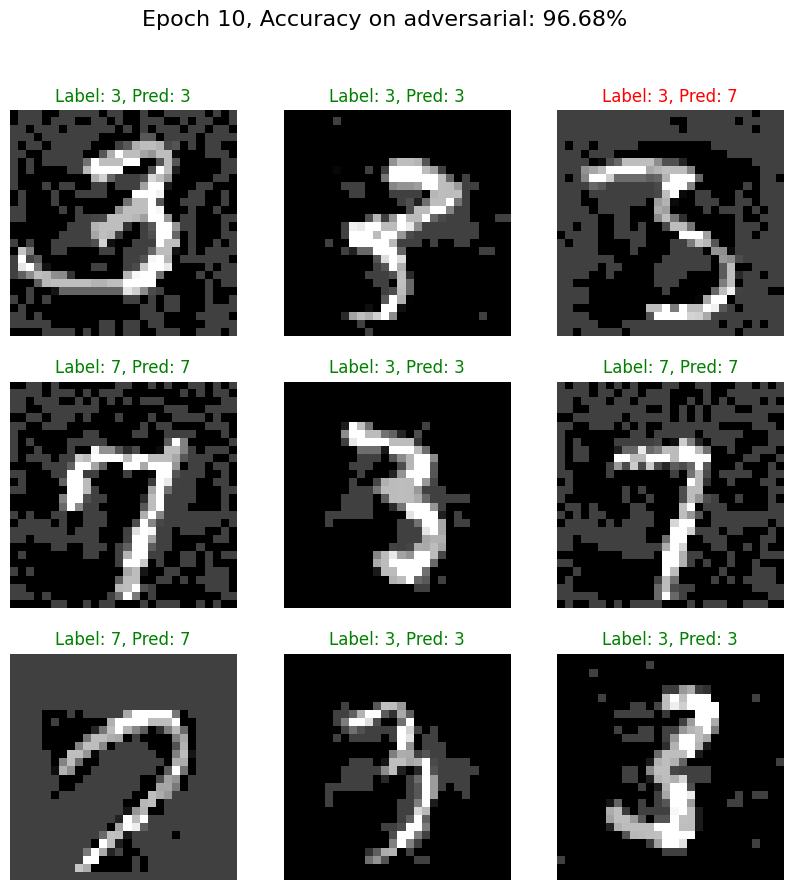

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images

# Définir une unité Maxout
class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_units):
        super(Maxout, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_units = num_units
        self.fc = nn.Linear(in_features, out_features * num_units)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.out_features, self.num_units)
        return torch.max(x, dim=2)[0]

# Classe du modèle Maxout (réseau Maxout agrandi)
class LargeMaxoutNN(nn.Module):
    def __init__(self):
        super(LargeMaxoutNN, self).__init__()
        self.fc1 = Maxout(28*28, 1600, 2)  # 1600 unités avec 2 activations maxout
        self.fc2 = Maxout(1600, 1600, 2)   # Deuxième couche avec 1600 unités
        self.fc3 = Maxout(1600, 10, 2)     # Couche de sortie avec 10 classes
        self.dropout = nn.Dropout(0.5)    # Dropout avec un taux de 50%

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Charger les données MNIST (avec uniquement des 3 et des 7)
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] == 3 or full_dataset.targets[i] == 7]
    filtered_dataset = Subset(full_dataset, indices)

    train_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales avec adversarial training
def train_on_adversarial_data(model, train_loader, optimizer, epsilon, lambda_adversarial, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # Obtenir les exemples adversariaux
            adversarial_images = FGSM(model, images, labels, epsilon)

            # Calculer la perte sur les images normales
            outputs = model(images)
            loss_normal = nn.CrossEntropyLoss()(outputs, labels)

            # Calculer la perte sur les images adversariales
            outputs_adv = model(adversarial_images)
            loss_adv = nn.CrossEntropyLoss()(outputs_adv, labels)

            # Perte combinée
            loss = loss_normal + lambda_adversarial * loss_adv
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()

    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.clone().detach().requires_grad_(True)
        adversarial_images = FGSM(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')
    return accuracy

# Calcul de la confiance moyenne sur les erreurs
# Test sur des données adversariales et calcul de la confiance moyenne
def test_and_analyze_confidence(model, data_loader, epsilon):
    model.eval()

    correct = 0
    total = 0
    total_confidence = 0
    total_misclassified = 0

    for images, labels in data_loader:
        # Générer des exemples adversariaux
        adversarial_images = FGSM(model, images, labels, epsilon)

        # Prédictions
        outputs = model(adversarial_images)
        probabilities = nn.Softmax(dim=1)(outputs)  # Calcul des probabilités via softmax
        confidence, predictions = torch.max(probabilities, 1)  # Confiance et classe prédite

        # Calcul de l'accuracy
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

        # Identifier les erreurs de classification
        misclassified = (predictions != labels)
        total_confidence += confidence[misclassified].sum().item()  # Somme des confiances sur les erreurs
        total_misclassified += misclassified.sum().item()  # Nombre total d'erreurs

    # Calcul de l'accuracy
    accuracy = 100 * correct / total

    # Calcul de la confiance moyenne sur les erreurs
    if total_misclassified > 0:
        avg_confidence = total_confidence / total_misclassified
    else:
        avg_confidence = 0  # Cas où il n'y a pas d'erreurs

    print(f"Accuracy on adversarial examples: {accuracy:.2f}%")
    print(f"Confiance moyenne sur les exemples mal classifiés : {avg_confidence * 100:.2f}%")

    return accuracy, avg_confidence


# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%", fontsize=16)
    plt.show()


# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    lambda_adversarial = 0.5  # Hyperparamètre pour la régularisation des exemples adversariaux
    epochs = 10 # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = LargeMaxoutNN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraîner sur des données avec adversarial training
    train_on_adversarial_data(model, train_loader, optimizer, epsilon, lambda_adversarial, epochs)

    # Tester sur des données adversariales
    accuracy, avg_confidence = test_and_analyze_confidence(model, train_loader, epsilon)

    # Calculer et afficher la confiance moyenne
    avg_confidence = analyze_confidence(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()
